#Emotion classifier

In [59]:
import tensorflow as tf
import csv

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [60]:
from bs4 import BeautifulSoup
import string

stopwords = ["a", "about", "above", "after", "again", "against", "all", "am", "an", "and", "any", "are", "as", "at",
             "be", "because", "been", "before", "being", "below", "between", "both", "but", "by", "could", "did", "do",
             "does", "doing", "down", "during", "each", "few", "for", "from", "further", "had", "has", "have", "having",
             "he", "hed", "hes", "her", "here", "heres", "hers", "herself", "him", "himself", "his", "how",
             "hows", "i", "id", "ill", "im", "ive", "if", "in", "into", "is", "it", "its", "itself",
             "lets", "me", "more", "most", "my", "myself", "nor", "of", "on", "once", "only", "or", "other", "ought",
             "our", "ours", "ourselves", "out", "over", "own", "same", "she", "shed", "shell", "shes", "should",
             "so", "some", "such", "than", "that", "thats", "the", "their", "theirs", "them", "themselves", "then",
             "there", "theres", "these", "they", "theyd", "theyll", "theyre", "theyve", "this", "those", "through",
             "to", "too", "under", "until", "up", "very", "was", "we", "wed", "well", "were", "weve", "were",
             "what", "whats", "when", "whens", "where", "wheres", "which", "while", "who", "whos", "whom", "why",
             "whys", "with", "would", "you", "youd", "youll", "youre", "youve", "your", "yours", "yourself",
             "yourselves"]

table = str.maketrans('', '', string.punctuation)

In [61]:
!wget --no-check-certificate --no-cache \
    https://storage.googleapis.com/laurencemoroney-blog.appspot.com/binary-emotion.csv \
    -O /tmp/binary-emotion.csv

--2022-05-13 18:57:49--  https://storage.googleapis.com/laurencemoroney-blog.appspot.com/binary-emotion.csv
Resolving storage.googleapis.com (storage.googleapis.com)... 209.85.147.128, 142.250.125.128, 142.250.136.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|209.85.147.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2690504 (2.6M) [text/csv]
Saving to: ‘/tmp/binary-emotion.csv’

/tmp/binary-emotion 100%[===================>]   2.57M  --.-KB/s    in 0.02s   

2022-05-13 18:57:49 (103 MB/s) - ‘/tmp/binary-emotion.csv’ saved [2690504/2690504]



In [62]:
sentences=[]
labels=[]
with open('/tmp/binary-emotion.csv', encoding='UTF-8') as csvfile:
  reader = csv.reader(csvfile, delimiter=",")
  for row in reader:
    labels.append(int(row[0]))
    sentence = row[1].lower()
    sentence = sentence.replace(",", " , ")
    sentence = sentence.replace(".", " . ")
    sentence = sentence.replace("-", " - ")
    sentence = sentence.replace("/", " / ")
    soup = BeautifulSoup(sentence)
    sentence = soup.get_text()
    words = sentence.split()
    filtered_sentence = ""
    for word in words:
        word = word.translate(table)
        if word not in stopwords:
            filtered_sentence = filtered_sentence + word + " "
    sentences.append(filtered_sentence)

print(len(labels))
print(len(sentences))

35327
35327


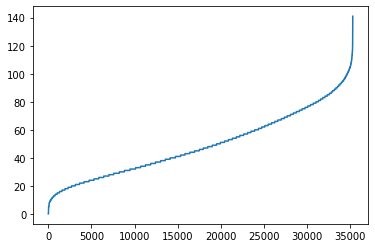

In [63]:
xs=[]
ys=[]
current_item=1
for item in sentences:
  xs.append(current_item)
  current_item=current_item+1
  ys.append(len(item))
newys = sorted(ys)

import matplotlib.pyplot as plt
plt.plot(xs,newys)
plt.show()

In [64]:
vocab_size = 2000
embedding_dim = 6
max_length = 100
trunc_type='post'
padding_type='post'
oov_tok = "<OOV>"
training_size = 28000

In [65]:
training_sentences = sentences[0:training_size]
testing_sentences = sentences[training_size:]
training_labels = labels[0:training_size]
testing_labels = labels[training_size:]

print(len(training_sentences), len(training_labels))
print(len(testing_sentences), len(testing_labels))

28000 28000
7327 7327


In [66]:
tokenizer = Tokenizer(num_words=vocab_size, oov_token=oov_tok)
tokenizer.fit_on_texts(training_sentences)

word_index = tokenizer.word_index

training_sequences = tokenizer.texts_to_sequences(training_sentences)
training_padded = pad_sequences(training_sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)

testing_sequences = tokenizer.texts_to_sequences(testing_sentences)
testing_padded = pad_sequences(testing_sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)


In [67]:
wc=tokenizer.word_counts
print(wc)

OrderedDict([('know', 1075), ('listenin', 7), ('bad', 589), ('habit', 4), ('earlier', 59), ('started', 72), ('freakin', 35), ('part', 88), ('layin', 2), ('n', 180), ('bed', 338), ('headache', 114), ('ughhhh', 7), ('waitin', 13), ('call', 199), ('wants', 125), ('hang', 63), ('friends', 279), ('soon', 326), ('want', 877), ('trade', 8), ('someone', 244), ('houston', 8), ('tickets', 78), ('no', 1623), ('one', 1111), ('will', 1017), ('re', 51), ('pinging', 4), ('didnt', 577), ('go', 1510), ('prom', 40), ('bc', 28), ('bf', 22), ('like', 1524), ('sleep', 425), ('not', 2258), ('thinking', 148), ('old', 244), ('friend', 215), ('married', 18), ('now', 1813), ('damn', 252), ('2', 815), ('scandalous', 1), ('hmmm', 40), ('djhero', 1), ('com', 960), ('charlene', 1), ('love', 1033), ('miss', 772), ('sorry', 593), ('least', 181), ('friday', 277), ('ugh', 227), ('beat', 34), ('stupid', 159), ('song', 173), ('get', 1686), ('next', 404), ('rude', 12), ('u', 954), ('watch', 257), ('hills', 15), ('london',

In [68]:
import numpy as np
training_padded = np.array(training_padded)
training_labels = np.array(training_labels)
testing_padded = np.array(testing_padded)
testing_labels = np.array(testing_labels)

In [69]:
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim),
    tf.keras.layers.GlobalAveragePooling1D(),
    tf.keras.layers.Dense(8, kernel_regularizer=tf.keras.regularizers.l2(0.025), activation='relu'),
    tf.keras.layers.Dense(4, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])
model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])

In [70]:
num_epochs = 70
history_emotion = model.fit(training_padded, training_labels, epochs=num_epochs, validation_data=(testing_padded, testing_labels), verbose=2)


Epoch 1/70
875/875 - 5s - loss: 0.7370 - accuracy: 0.5235 - val_loss: 0.6711 - val_accuracy: 0.8241 - 5s/epoch - 6ms/step
Epoch 2/70
875/875 - 4s - loss: 0.6923 - accuracy: 0.5235 - val_loss: 0.6611 - val_accuracy: 0.8241 - 4s/epoch - 5ms/step
Epoch 3/70
875/875 - 4s - loss: 0.6921 - accuracy: 0.5235 - val_loss: 0.6662 - val_accuracy: 0.8241 - 4s/epoch - 5ms/step
Epoch 4/70
875/875 - 4s - loss: 0.6921 - accuracy: 0.5235 - val_loss: 0.6592 - val_accuracy: 0.8241 - 4s/epoch - 4ms/step
Epoch 5/70
875/875 - 4s - loss: 0.6920 - accuracy: 0.5235 - val_loss: 0.6633 - val_accuracy: 0.8241 - 4s/epoch - 5ms/step
Epoch 6/70
875/875 - 4s - loss: 0.6855 - accuracy: 0.5699 - val_loss: 0.6137 - val_accuracy: 0.8070 - 4s/epoch - 5ms/step
Epoch 7/70
875/875 - 4s - loss: 0.6333 - accuracy: 0.6834 - val_loss: 0.5667 - val_accuracy: 0.7661 - 4s/epoch - 5ms/step
Epoch 8/70
875/875 - 4s - loss: 0.6025 - accuracy: 0.7019 - val_loss: 0.5214 - val_accuracy: 0.7921 - 4s/epoch - 4ms/step
Epoch 9/70
875/875 - 4s 

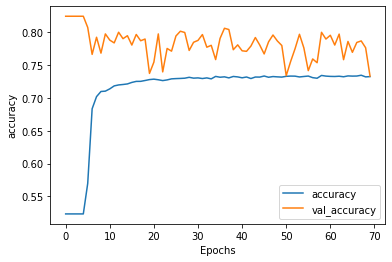

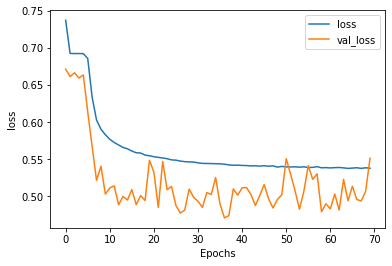

In [71]:
import matplotlib.pyplot as plt


def plot_graphs(history, string):
  plt.plot(history_emotion.history[string])
  plt.plot(history_emotion.history['val_'+string])
  plt.xlabel("Epochs")
  plt.ylabel(string)
  plt.legend([string, 'val_'+string])
  plt.show()
  
plot_graphs(history_emotion, "accuracy")
plot_graphs(history_emotion, "loss")

In [72]:
sentence = ["I'm really upset right now and not happy with you! ANGRY!", "She said yes! We're getting married! Wow!"]
sequences = tokenizer.texts_to_sequences(sentence)
print(sequences)
padded = pad_sequences(sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)
print(model.predict(padded))

[[1, 22, 526, 57, 4, 1, 3, 55, 1, 1, 1475], [1, 174, 107, 1, 66, 1609, 172]]
[[0.04992945]
 [0.7348551 ]]


#Sarcasm Classifier

In [34]:
import json
import tensorflow as tf

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [35]:
from bs4 import BeautifulSoup
import string

stopwords = ["a", "about", "above", "after", "again", "against", "all", "am", "an", "and", "any", "are", "as", "at",
             "be", "because", "been", "before", "being", "below", "between", "both", "but", "by", "could", "did", "do",
             "does", "doing", "down", "during", "each", "few", "for", "from", "further", "had", "has", "have", "having",
             "he", "hed", "hes", "her", "here", "heres", "hers", "herself", "him", "himself", "his", "how",
             "hows", "i", "id", "ill", "im", "ive", "if", "in", "into", "is", "it", "its", "itself",
             "lets", "me", "more", "most", "my", "myself", "nor", "of", "on", "once", "only", "or", "other", "ought",
             "our", "ours", "ourselves", "out", "over", "own", "same", "she", "shed", "shell", "shes", "should",
             "so", "some", "such", "than", "that", "thats", "the", "their", "theirs", "them", "themselves", "then",
             "there", "theres", "these", "they", "theyd", "theyll", "theyre", "theyve", "this", "those", "through",
             "to", "too", "under", "until", "up", "very", "was", "we", "wed", "well", "were", "weve", "were",
             "what", "whats", "when", "whens", "where", "wheres", "which", "while", "who", "whos", "whom", "why",
             "whys", "with", "would", "you", "youd", "youll", "youre", "youve", "your", "yours", "yourself",
             "yourselves"]

table = str.maketrans('', '', string.punctuation)

In [36]:
!wget --no-check-certificate \
    https://storage.googleapis.com/laurencemoroney-blog.appspot.com/sarcasm.json \
    -O /tmp/sarcasm.json

--2022-05-13 18:52:55--  https://storage.googleapis.com/laurencemoroney-blog.appspot.com/sarcasm.json
Resolving storage.googleapis.com (storage.googleapis.com)... 142.250.136.128, 142.250.148.128, 108.177.112.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|142.250.136.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 5643545 (5.4M) [application/json]
Saving to: ‘/tmp/sarcasm.json’

/tmp/sarcasm.json   100%[===================>]   5.38M  --.-KB/s    in 0.04s   

2022-05-13 18:52:55 (129 MB/s) - ‘/tmp/sarcasm.json’ saved [5643545/5643545]



In [37]:
import json
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

with open("/tmp/sarcasm.json", 'r') as f:
    datastore = json.load(f)


sentences = [] 
labels = []
urls = []
for item in datastore:
    sentence = item['headline'].lower()
    sentence = sentence.replace(",", " , ")
    sentence = sentence.replace(".", " . ")
    sentence = sentence.replace("-", " - ")
    sentence = sentence.replace("/", " / ")
    soup = BeautifulSoup(sentence)
    sentence = soup.get_text()
    words = sentence.split()
    filtered_sentence = ""
    for word in words:
        word = word.translate(table)
        if word not in stopwords:
            filtered_sentence = filtered_sentence + word + " "
    sentences.append(filtered_sentence)
    labels.append(item['is_sarcastic'])
    urls.append(item['article_link'])

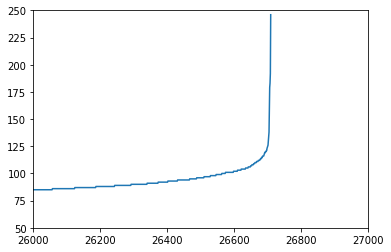

85


In [38]:
xs=[]
ys=[]
current_item=1
for item in sentences:
  xs.append(current_item)
  current_item=current_item+1
  ys.append(len(item))
newys = sorted(ys)

import matplotlib.pyplot as plt
plt.plot(xs,newys)
plt.axis([26000, 27000, 50, 250])
plt.show()

print(newys[26000])

In [39]:
vocab_size = 10000
embedding_dim = 16
max_length = 100
trunc_type='post'
padding_type='post'
oov_tok = "<OOV>"
training_size = 23000

In [40]:
training_sentences = sentences[0:training_size]
testing_sentences = sentences[training_size:]
training_labels = labels[0:training_size]
testing_labels = labels[training_size:]

In [41]:
print(len(training_sentences), len(training_labels))
print(len(testing_sentences), len(testing_labels))

23000 23000
3709 3709


In [42]:
tokenizer = Tokenizer(num_words=vocab_size, oov_token=oov_tok)
tokenizer.fit_on_texts(training_sentences)

word_index = tokenizer.word_index

training_sequences = tokenizer.texts_to_sequences(training_sentences)
print(len(training_sequences))
training_padded = pad_sequences(training_sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)

testing_sequences = tokenizer.texts_to_sequences(testing_sentences)
testing_padded = pad_sequences(testing_sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)


23000


In [43]:
print(len(training_sequences), len(training_padded))
print(len(testing_sequences), len(testing_padded))


23000 23000
3709 3709


In [44]:
wc=tokenizer.word_counts
print(wc)

OrderedDict([('former', 90), ('versace', 1), ('store', 44), ('clerk', 9), ('sues', 13), ('secret', 78), ('black', 230), ('code', 19), ('minority', 12), ('shoppers', 2), ('roseanne', 3), ('revival', 10), ('catches', 10), ('thorny', 3), ('political', 73), ('mood', 13), ('better', 100), ('worse', 34), ('mom', 163), ('starting', 37), ('fear', 39), ('sons', 35), ('web', 16), ('series', 53), ('closest', 5), ('thing', 126), ('will', 484), ('grandchild', 2), ('boehner', 26), ('just', 501), ('wants', 120), ('wife', 73), ('listen', 21), ('not', 634), ('come', 92), ('alternative', 13), ('debt', 23), ('reduction', 4), ('ideas', 35), ('j', 41), ('k', 39), ('rowling', 5), ('wishes', 33), ('snape', 2), ('happy', 51), ('birthday', 57), ('magical', 25), ('way', 239), ('advancing', 2), ('worlds', 79), ('women', 289), ('fascinating', 3), ('case', 77), ('eating', 64), ('lab', 8), ('grown', 17), ('meat', 25), ('ceo', 56), ('send', 33), ('kids', 164), ('school', 207), ('work', 168), ('company', 78), ('top',

{'<OOV>': 1, 'new': 2, 'trump': 3, 'man': 4, 'not': 5, 'just': 6, 'will': 7, 'one': 8, 'year': 9, 'report': 10, 'area': 11, 'donald': 12, 'day': 13, 'u': 14, 's': 15, 'can': 16, 'says': 17, 'woman': 18, 'first': 19, 'time': 20, 'like': 21, 'no': 22, 'get': 23, 'old': 24, 'trumps': 25, 'off': 26, 'now': 27, 'life': 28, 'obama': 29, 'people': 30, 'house': 31, 'women': 32, 'white': 33, 'back': 34, 'still': 35, 'make': 36, 'clinton': 37, '5': 38, 'world': 39, 'americans': 40, 'years': 41, 'way': 42, 'family': 43, 'black': 44, 'study': 45, 'gop': 46, 'best': 47, 'bill': 48, 'american': 49, 'school': 50, 'police': 51, 'watch': 52, '3': 53, 'show': 54, 'really': 55, 'president': 56, 'home': 57, 'last': 58, 'video': 59, 'finds': 60, 'death': 61, 'cant': 62, 'know': 63, '10': 64, 'things': 65, 'good': 66, 'going': 67, 'state': 68, 'hillary': 69, 'love': 70, 'nation': 71, 'may': 72, '2': 73, 'health': 74, 'say': 75, 'parents': 76, 'big': 77, 'every': 78, 'right': 79, 'work': 80, '000': 81, 'need

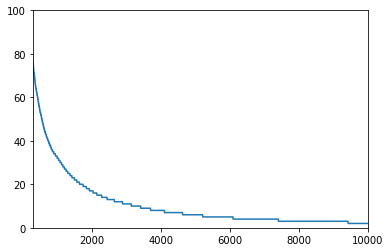

32
17


In [45]:
import matplotlib.pyplot as plt
wc = tokenizer.word_counts
from collections import OrderedDict
newlist = (OrderedDict(sorted(wc.items(), key=lambda t: t[1], reverse=True)))
print(word_index)
print(newlist)
xs=[]
ys=[]
curr_x = 1
for item in newlist:
  xs.append(curr_x)
  curr_x=curr_x+1
  ys.append(newlist[item])

print(ys)
plt.plot(xs,ys)
plt.axis([300,10000,0,100])
plt.show()
print(ys[1000])
print(ys[2000])

In [46]:
print(ys[3125])
print(ys[10000])
print(ys[12156])

11
2
2


In [47]:
print(len(training_sequences), len(training_padded))
print(len(testing_sequences), len(testing_padded))

23000 23000
3709 3709


In [48]:
import numpy as np
training_padded = np.array(training_padded)
training_labels = np.array(training_labels)
testing_padded = np.array(testing_padded)
testing_labels = np.array(testing_labels)

In [49]:
print(len(training_padded), len(training_labels))

23000 23000


In [50]:
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim),
    tf.keras.layers.GlobalAveragePooling1D(),
    tf.keras.layers.Dense(24, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])
adam = tf.keras.optimizers.Adam(learning_rate=0.0001, beta_1=0.9, beta_2=0.999, amsgrad=False)
model.compile(loss='binary_crossentropy',optimizer=adam, metrics=['accuracy'])


In [51]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, None, 16)          160000    
                                                                 
 global_average_pooling1d_2   (None, 16)               0         
 (GlobalAveragePooling1D)                                        
                                                                 
 dense_7 (Dense)             (None, 24)                408       
                                                                 
 dense_8 (Dense)             (None, 1)                 25        
                                                                 
Total params: 160,433
Trainable params: 160,433
Non-trainable params: 0
_________________________________________________________________


In [52]:
num_epochs = 70
history_sarcasm = model.fit(training_padded, training_labels, epochs=num_epochs, validation_data=(testing_padded, testing_labels), verbose=2)


Epoch 1/70
719/719 - 4s - loss: 0.6911 - accuracy: 0.5426 - val_loss: 0.6881 - val_accuracy: 0.5700 - 4s/epoch - 6ms/step
Epoch 2/70
719/719 - 3s - loss: 0.6875 - accuracy: 0.5596 - val_loss: 0.6848 - val_accuracy: 0.5700 - 3s/epoch - 5ms/step
Epoch 3/70
719/719 - 3s - loss: 0.6856 - accuracy: 0.5596 - val_loss: 0.6830 - val_accuracy: 0.5700 - 3s/epoch - 5ms/step
Epoch 4/70
719/719 - 4s - loss: 0.6845 - accuracy: 0.5596 - val_loss: 0.6820 - val_accuracy: 0.5700 - 4s/epoch - 6ms/step
Epoch 5/70
719/719 - 3s - loss: 0.6833 - accuracy: 0.5596 - val_loss: 0.6806 - val_accuracy: 0.5700 - 3s/epoch - 5ms/step
Epoch 6/70
719/719 - 3s - loss: 0.6816 - accuracy: 0.5596 - val_loss: 0.6786 - val_accuracy: 0.5700 - 3s/epoch - 5ms/step
Epoch 7/70
719/719 - 4s - loss: 0.6791 - accuracy: 0.5596 - val_loss: 0.6759 - val_accuracy: 0.5700 - 4s/epoch - 6ms/step
Epoch 8/70
719/719 - 3s - loss: 0.6750 - accuracy: 0.5597 - val_loss: 0.6715 - val_accuracy: 0.5700 - 3s/epoch - 5ms/step
Epoch 9/70
719/719 - 3s 

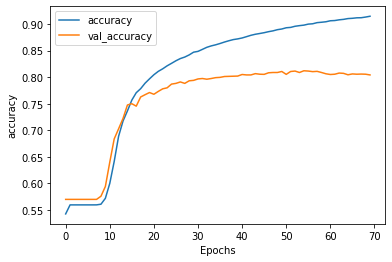

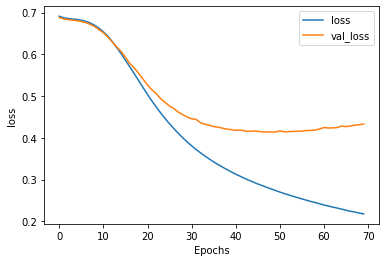

In [53]:
import matplotlib.pyplot as plt


def plot_graphs(history, string):
  plt.plot(history_sarcasm.history[string])
  plt.plot(history_sarcasm.history['val_'+string])
  plt.xlabel("Epochs")
  plt.ylabel(string)
  plt.legend([string, 'val_'+string])
  plt.show()
  
plot_graphs(history_sarcasm, "accuracy")
plot_graphs(history_sarcasm, "loss")

In [54]:
reverse_word_index = dict([(value, key) for (key, value) in word_index.items()])

def decode_sentence(text):
    return ' '.join([reverse_word_index.get(i, '?') for i in text])

print(decode_sentence(training_padded[0]))
print(training_sentences[2])
print(labels[2])

former <OOV> store clerk sues secret black code minority shoppers ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ?
mom starting fear sons web series closest thing will grandchild 
1


In [55]:
e = model.layers[0]
weights = e.get_weights()[0]
print(weights.shape) # shape: (vocab_size, embedding_dim)
print(reverse_word_index[2])
print(weights[2])

(10000, 16)
new
[-0.10100646 -0.16272783  0.06243275  0.09756996  0.10151697  0.17351244
  0.1434871   0.11355238 -0.12085898 -0.07323047  0.13306218  0.12989877
  0.11541551  0.10190384  0.12215562  0.08905401]


In [56]:
import io

out_v = io.open('vecs.tsv', 'w', encoding='utf-8')
out_m = io.open('meta.tsv', 'w', encoding='utf-8')
for word_num in range(1, vocab_size):
  word = reverse_word_index[word_num]
  embeddings = weights[word_num]
  out_m.write(word + "\n")
  out_v.write('\t'.join([str(x) for x in embeddings]) + "\n")
out_v.close()
out_m.close()

In [57]:
try:
  from google.colab import files
except ImportError:
  pass
else:
  files.download('vecs.tsv')
  files.download('meta.tsv')
sentences = ["granny starting to fear spiders in the garden might be real", "game of thrones season finale showing this sunday night", "TensorFlow book will be a best seller"]
sequences = tokenizer.texts_to_sequences(sentences)
print(sequences)
padded = pad_sequences(sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)
print(padded)
print(model.predict(padded))

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

[[1, 803, 1, 753, 1, 1, 1, 2592, 312, 1, 97], [123, 1, 1183, 160, 2646, 3236, 1, 1543, 152], [1, 235, 7, 1, 1, 47, 1]]
[[   1  803    1  753    1    1    1 2592  312    1   97    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0]
 [ 123    1 1183  160 2646 3236    1 1543  152    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
    

#Sarcasm swivel

In [73]:
import json
import tensorflow as tf
import numpy as np

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [74]:
from bs4 import BeautifulSoup
import string

stopwords = ["a", "about", "above", "after", "again", "against", "all", "am", "an", "and", "any", "are", "as", "at",
             "be", "because", "been", "before", "being", "below", "between", "both", "but", "by", "could", "did", "do",
             "does", "doing", "down", "during", "each", "few", "for", "from", "further", "had", "has", "have", "having",
             "he", "hed", "hes", "her", "here", "heres", "hers", "herself", "him", "himself", "his", "how",
             "hows", "i", "id", "ill", "im", "ive", "if", "in", "into", "is", "it", "its", "itself",
             "lets", "me", "more", "most", "my", "myself", "nor", "of", "on", "once", "only", "or", "other", "ought",
             "our", "ours", "ourselves", "out", "over", "own", "same", "she", "shed", "shell", "shes", "should",
             "so", "some", "such", "than", "that", "thats", "the", "their", "theirs", "them", "themselves", "then",
             "there", "theres", "these", "they", "theyd", "theyll", "theyre", "theyve", "this", "those", "through",
             "to", "too", "under", "until", "up", "very", "was", "we", "wed", "well", "were", "weve", "were",
             "what", "whats", "when", "whens", "where", "wheres", "which", "while", "who", "whos", "whom", "why",
             "whys", "with", "would", "you", "youd", "youll", "youre", "youve", "your", "yours", "yourself",
             "yourselves"]

table = str.maketrans('', '', string.punctuation)

In [75]:
!wget --no-check-certificate \
    https://storage.googleapis.com/laurencemoroney-blog.appspot.com/sarcasm.json \
    -O /tmp/sarcasm.json

--2022-05-13 19:10:43--  https://storage.googleapis.com/laurencemoroney-blog.appspot.com/sarcasm.json
Resolving storage.googleapis.com (storage.googleapis.com)... 209.85.146.128, 209.85.147.128, 142.250.148.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|209.85.146.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 5643545 (5.4M) [application/json]
Saving to: ‘/tmp/sarcasm.json’

/tmp/sarcasm.json   100%[===================>]   5.38M  --.-KB/s    in 0.04s   

2022-05-13 19:10:43 (132 MB/s) - ‘/tmp/sarcasm.json’ saved [5643545/5643545]



In [76]:
import json
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

with open("/tmp/sarcasm.json", 'r') as f:
    datastore = json.load(f)


sentences = [] 
labels = []
urls = []
for item in datastore:
    sentence = item['headline'].lower()
    sentence = sentence.replace(",", " , ")
    sentence = sentence.replace(".", " . ")
    sentence = sentence.replace("-", " - ")
    sentence = sentence.replace("/", " / ")
    soup = BeautifulSoup(sentence)
    sentence = soup.get_text()
    words = sentence.split()
    filtered_sentence = ""
    for word in words:
        word = word.translate(table)
        if word not in stopwords:
            filtered_sentence = filtered_sentence + word + " "
    sentences.append(filtered_sentence)
    labels.append(item['is_sarcastic'])
    urls.append(item['article_link'])

In [77]:
training_size = 24000
training_sentences = sentences[0:training_size]
testing_sentences = sentences[training_size:]
training_labels = labels[0:training_size]
testing_labels = labels[training_size:]

In [78]:
import tensorflow_hub as hub
hub_layer = hub.KerasLayer("https://tfhub.dev/google/tf2-preview/gnews-swivel-20dim/1", output_shape=[20], input_shape=[], dtype=tf.string, trainable=False)


In [79]:
model = tf.keras.Sequential([
    hub_layer,
    tf.keras.layers.Dense(16, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])
adam = tf.keras.optimizers.Adam(learning_rate=0.0001, beta_1=0.9, beta_2=0.999, amsgrad=False)
model.compile(loss='binary_crossentropy',optimizer=adam, metrics=['accuracy'])
model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer (KerasLayer)    (None, 20)                400020    
                                                                 
 dense_12 (Dense)            (None, 16)                336       
                                                                 
 dense_13 (Dense)            (None, 1)                 17        
                                                                 
Total params: 400,373
Trainable params: 353
Non-trainable params: 400,020
_________________________________________________________________


In [80]:
num_epochs = 50
history = model.fit(training_sentences, training_labels, epochs=num_epochs, validation_data=(testing_sentences, testing_labels), verbose=2)


Epoch 1/50
750/750 - 3s - loss: 0.6873 - accuracy: 0.5638 - val_loss: 0.6740 - val_accuracy: 0.5677 - 3s/epoch - 5ms/step
Epoch 2/50
750/750 - 3s - loss: 0.6674 - accuracy: 0.5914 - val_loss: 0.6621 - val_accuracy: 0.5980 - 3s/epoch - 3ms/step
Epoch 3/50
750/750 - 3s - loss: 0.6581 - accuracy: 0.6084 - val_loss: 0.6553 - val_accuracy: 0.6161 - 3s/epoch - 3ms/step
Epoch 4/50
750/750 - 3s - loss: 0.6520 - accuracy: 0.6200 - val_loss: 0.6498 - val_accuracy: 0.6202 - 3s/epoch - 3ms/step
Epoch 5/50
750/750 - 3s - loss: 0.6472 - accuracy: 0.6290 - val_loss: 0.6449 - val_accuracy: 0.6283 - 3s/epoch - 3ms/step
Epoch 6/50
750/750 - 3s - loss: 0.6435 - accuracy: 0.6359 - val_loss: 0.6415 - val_accuracy: 0.6386 - 3s/epoch - 3ms/step
Epoch 7/50
750/750 - 3s - loss: 0.6403 - accuracy: 0.6419 - val_loss: 0.6388 - val_accuracy: 0.6419 - 3s/epoch - 3ms/step
Epoch 8/50
750/750 - 3s - loss: 0.6376 - accuracy: 0.6453 - val_loss: 0.6364 - val_accuracy: 0.6430 - 3s/epoch - 3ms/step
Epoch 9/50
750/750 - 3s 

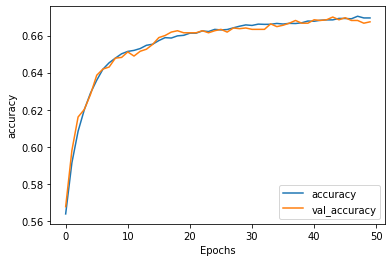

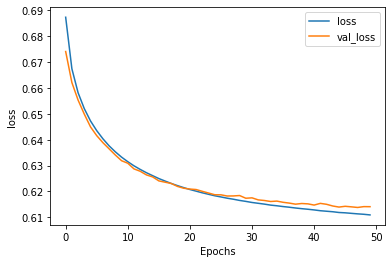

In [81]:
import matplotlib.pyplot as plt


def plot_graphs(history, string):
  plt.plot(history.history[string])
  plt.plot(history.history['val_'+string])
  plt.xlabel("Epochs")
  plt.ylabel(string)
  plt.legend([string, 'val_'+string])
  plt.show()
  
plot_graphs(history, "accuracy")
plot_graphs(history, "loss")

In [82]:
test_sentences = ["granny starting to fear spiders in the garden might be real", 
 "game of thrones season finale showing this sunday night", 
 "TensorFlow book will be a best seller"]

predictions = model.predict(test_sentences)
print(predictions)

[[0.60762316]
 [0.19331846]
 [0.5315862 ]]
